In [ ]:
#!git clone https://github.com/Rolf110/llm_interpretability/

In [ ]:
#!pip install dotenv

In [ ]:
#!pip install datasets

In [ ]:
#!pip install transformer_lens

In [1]:
from huggingface_hub import login

login('')


/home/jovyan/.mlspace/envs/tai_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
import os
import re
import functools
from datetime import datetime
from pathlib import Path

import dotenv
from datasets import load_dataset
from tqdm.auto import tqdm
from transformer_lens import HookedTransformer

import torch
import plotly.express as px

dotenv.load_dotenv()

MODEL_NAME = "google/gemma-2b-it"
MODEL_NAME_BASE = "google/gemma-2b"
HF_DATASET_NAME = "walledai/HarmBench"
CACHE_DIR = "./cached_models/"
OUTPUT_DIR = "./output"
ANSWER_SPLITTER = "\n\n\n"
DEVICE = "cuda:0"

safety_heads = [
    (0, 4),
    (0, 6),
    (1, 3),
    (3, 1),
    (3, 2),
    (3, 5),
    (4, 5),
    (4, 6),
    (4, 7),
    (5, 2),
    (5, 6),
    (5, 7),
    (6, 1),
    (6, 4),
    (6, 5),
    (7, 1),
    (7, 2),
    (7, 3),
    (9, 1),
    (9, 2),
    (9, 3),
    (10, 1),
    (11, 1),
    (11, 6),
    (12, 2),
    (12, 3),
    (13, 1),
    (13, 2),
    (14, 0),
    (14, 1),
    (14, 5),
    (15, 2),
    (15, 4),
    (15, 5),
    (15, 6),
    (15, 7),
    (16, 1),
    (16, 3),
    (16, 5),
    (16, 7),
    (17, 2),
    (17, 3),
    (17, 7),
]


def prepare_prompt(prompt: str) -> str:
    harmful_prompt = "<bos><start_of_turn>user\n"
    harmful_prompt += prompt
    harmful_prompt += "\n<start_of_turn>model"
    return harmful_prompt


def sanitize_filename(name: str) -> str:
    return re.sub(r"[^a-zA-Z0-9_-]", "_", name)


def get_output_filename() -> str:
    model_safe = sanitize_filename(MODEL_NAME)
    dataset_safe = sanitize_filename(HF_DATASET_NAME)
    timestamp = datetime.now().isoformat(timespec="seconds")
    #return f"zero_ablation|{model_safe}|{dataset_safe}|{timestamp}.txt"
    #return f"mean_ablation|{model_safe}|{dataset_safe}|{timestamp}.txt"
    return f"random_ablation|{model_safe}|{dataset_safe}|{timestamp}.txt"

def head_ablation_hook(
    attn_result,
    hook,
    head_index_to_ablate
):
    attn_result[:, :, head_index_to_ablate, :] = 0.0
    return attn_result

def head_ablation_hook_mean(
    attn_result,
    hook,
    head_index_to_ablate
):
    
    attn_result[:, :, head_index_to_ablate, :] = attn_result[:, :, head_index_to_ablate, :].mean()
    return attn_result

import random

def head_ablation_hook_random(
    attn_result,
    hook,
    head_index_to_ablate
):
    idx = random.randrange(attn_result[:, :, head_index_to_ablate, :].numel())
    attn_result[:, :, head_index_to_ablate, :] = attn_result[:, :, head_index_to_ablate, :].flatten()[idx]
    return attn_result



def run_model_with_ablated_heads(
    model,
    prompt,
    heads_to_ablate,
    **generation_kwargs
):
    model.reset_hooks()

    if isinstance(prompt, str):
        tokens = model.to_tokens(prompt)
    else:
        tokens = prompt

    _, base_cache = model.run_with_cache(tokens, remove_batch_dim=True)

    hooks = []
    for layer, head in heads_to_ablate:
        hook_fn = functools.partial(head_ablation_hook, head_index_to_ablate=head)
        hook_point = f"blocks.{layer}.attn.hook_z"
        hook = model.add_hook(hook_point, hook_fn)
        hooks.append(hook)

    if isinstance(prompt, str):
        tokens = model.to_tokens(prompt)
    else:
        tokens = prompt

    _, cache = model.run_with_cache(tokens, remove_batch_dim=True)

    similarities=[]
    for name, param in cache.items():
      similarities.append(torch.cosine_similarity(param, base_cache[name]))

    output = model.generate(
        tokens,
        verbose=False,
        **generation_kwargs
    ).squeeze()

    model.reset_hooks()

    return model.to_string(output), similarities

def run_model_with_ablated_heads_mean(
    model,
    prompt,
    heads_to_ablate,
    **generation_kwargs
):
    model.reset_hooks()

    hooks = []
    for layer, head in heads_to_ablate:
        hook_fn = functools.partial(head_ablation_hook_mean, head_index_to_ablate=head)
        hook_point = f"blocks.{layer}.attn.hook_z"
        hook = model.add_hook(hook_point, hook_fn)
        hooks.append(hook)

    if isinstance(prompt, str):
        tokens = model.to_tokens(prompt)
    else:
        tokens = prompt

    output = model.generate(
        tokens,
        verbose=False,
        **generation_kwargs
    ).squeeze()

    model.reset_hooks()

    return model.to_string(output)

def run_model_with_ablated_heads_random(
    model,
    prompt,
    heads_to_ablate,
    **generation_kwargs
):
    model.reset_hooks()

    hooks = []
    for layer, head in heads_to_ablate:
        hook_fn = functools.partial(head_ablation_hook_random, head_index_to_ablate=head)
        hook_point = f"blocks.{layer}.attn.hook_z"
        hook = model.add_hook(hook_point, hook_fn)
        hooks.append(hook)

    if isinstance(prompt, str):
        tokens = model.to_tokens(prompt)
    else:
        tokens = prompt

    output = model.generate(
        tokens,
        verbose=False,
        **generation_kwargs
    ).squeeze()

    model.reset_hooks()

    return model.to_string(output)

def get_safety_heads(model, prompt, heads_to_ablate):
    model.reset_hooks()

    if isinstance(prompt, str):
        tokens = model.to_tokens(prompt)
    else:
        tokens = prompt

    _, base_cache = model.run_with_cache(tokens, remove_batch_dim=True)

    safe_cache = {}
    for layer, head in heads_to_ablate:
        safe_cache[(layer, head)] = base_cache["pattern", layer][head]
    
    return safe_cache
def main():
    Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
    output_path = Path(OUTPUT_DIR) / get_output_filename()

    dataset = load_dataset(
        HF_DATASET_NAME,
        "standard",
        cache_dir=os.getenv("HarmBench_dir", None)
    )

    model = HookedTransformer.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR).cuda()

    answers = []
    similarities=[]
    for prompt in tqdm(dataset["train"]["prompt"]): 
        harmful_prompt = prepare_prompt(prompt)
        output, sims = run_model_with_ablated_heads(
            model,
            harmful_prompt,
            heads_to_ablate=safety_heads,
            max_new_tokens=256
        )
        similarities.append(sims)
        answers.append(output)
        px.histogram(
          similarities,
          nbins=50,
          title=f"HISTOGRAM OF COSINE SIMILARITIES",
          labels={"value": "Activation"},
          width=800,
          template="ggplot2",
          color_discrete_sequence=["darkorange"],
          ).update_layout(bargap=0.02, showlegend=False).show()

    with open(output_path, "a", encoding="utf-8") as f:
        f.write(ANSWER_SPLITTER.join(answers))


In [44]:
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
output_path = Path(OUTPUT_DIR) / get_output_filename()

dataset = load_dataset(
    HF_DATASET_NAME,
    "standard",
    cache_dir=os.getenv("HarmBench_dir", None)
)
    
model = HookedTransformer.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)
    
answers = []
for prompt in tqdm(dataset["train"]["prompt"]): 
    harmful_prompt = prepare_prompt(prompt)
        
    output = run_model_with_ablated_heads_mean(
        model, 
        harmful_prompt, 
        heads_to_ablate=safety_heads,
        max_new_tokens=256
    )
    answers.append(output)
    
with open(output_path, "a", encoding="utf-8") as f:
    f.write(ANSWER_SPLITTER.join(answers))

Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.94s/it]


Loaded pretrained model google/gemma-2b-it into HookedTransformer


100%|██████████| 200/200 [10:47<00:00,  3.24s/it]


In [46]:
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
output_path = Path(OUTPUT_DIR) / get_output_filename()

dataset = load_dataset(
    HF_DATASET_NAME,
    "standard",
    cache_dir=os.getenv("HarmBench_dir", None)
)
    
model = HookedTransformer.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR)
    
answers = []
for prompt in tqdm(dataset["train"]["prompt"]): 
    harmful_prompt = prepare_prompt(prompt)
        
    output = run_model_with_ablated_heads_random(
        model, 
        harmful_prompt, 
        heads_to_ablate=safety_heads,
        max_new_tokens=256
    )
    answers.append(output)
    
with open(output_path, "a", encoding="utf-8") as f:
    f.write(ANSWER_SPLITTER.join(answers))

Loading checkpoint shards: 100%|██████████| 2/2 [00:05<00:00,  2.68s/it]


Loaded pretrained model google/gemma-2b-it into HookedTransformer


100%|██████████| 200/200 [10:59<00:00,  3.30s/it]


In [3]:
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
output_path = Path(OUTPUT_DIR) / get_output_filename()

dataset = load_dataset(
    HF_DATASET_NAME,
    "standard",
    cache_dir=os.getenv("HarmBench_dir", None)
)

model = HookedTransformer.from_pretrained(MODEL_NAME, cache_dir=CACHE_DIR).cuda()

model_heads = []

for prompt in tqdm(dataset["train"]["prompt"]): 
    harmful_prompt = prepare_prompt(prompt)
    cache = get_safety_heads(model, harmful_prompt, safety_heads)
    model_heads.append(cache)

Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.31s/it]


Loaded pretrained model google/gemma-2b-it into HookedTransformer
Moving model to device:  cuda


100%|██████████| 200/200 [00:15<00:00, 12.73it/s]


In [4]:
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
output_path = Path(OUTPUT_DIR) / get_output_filename()

dataset = load_dataset(
    HF_DATASET_NAME,
    "standard",
    cache_dir=os.getenv("HarmBench_dir", None)
)

model_base = HookedTransformer.from_pretrained(MODEL_NAME_BASE, cache_dir=CACHE_DIR).cuda()

model_heads_base = []

for prompt in tqdm(dataset["train"]["prompt"]):
    harmful_prompt = prepare_prompt(prompt)
    cache_base = get_safety_heads(model_base, harmful_prompt, safety_heads)
    model_heads_base.append(cache_base)

Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.46s/it]


Loaded pretrained model google/gemma-2b into HookedTransformer
Moving model to device:  cuda


100%|██████████| 200/200 [00:17<00:00, 11.64it/s]


In [17]:
model_heads[0][safety_heads[0]].flatten().squeeze().shape

torch.Size([576])

In [23]:
heads_scores = []
for idx in range(len(safety_heads)):
    scores = []
    for prompt_idx in range(200):
        scores.append(torch.cosine_similarity(model_heads[prompt_idx][safety_heads[idx]].reshape((1, -1)), model_heads_base[prompt_idx][safety_heads[idx]].reshape((1, -1))).item())
    heads_scores.append(scores)

In [ ]:
import matplotlib.pyplot as plt
for idx in range(len(safety_heads)):
    plt.figure(figsize=(15, 10))
    plt.hist(heads_scores[idx])
    plt.title(f'Cosine similarities scores for base and instruct models, head {safety_heads[idx]}')
    plt.savefig(f'head_{safety_heads[idx]}.png')

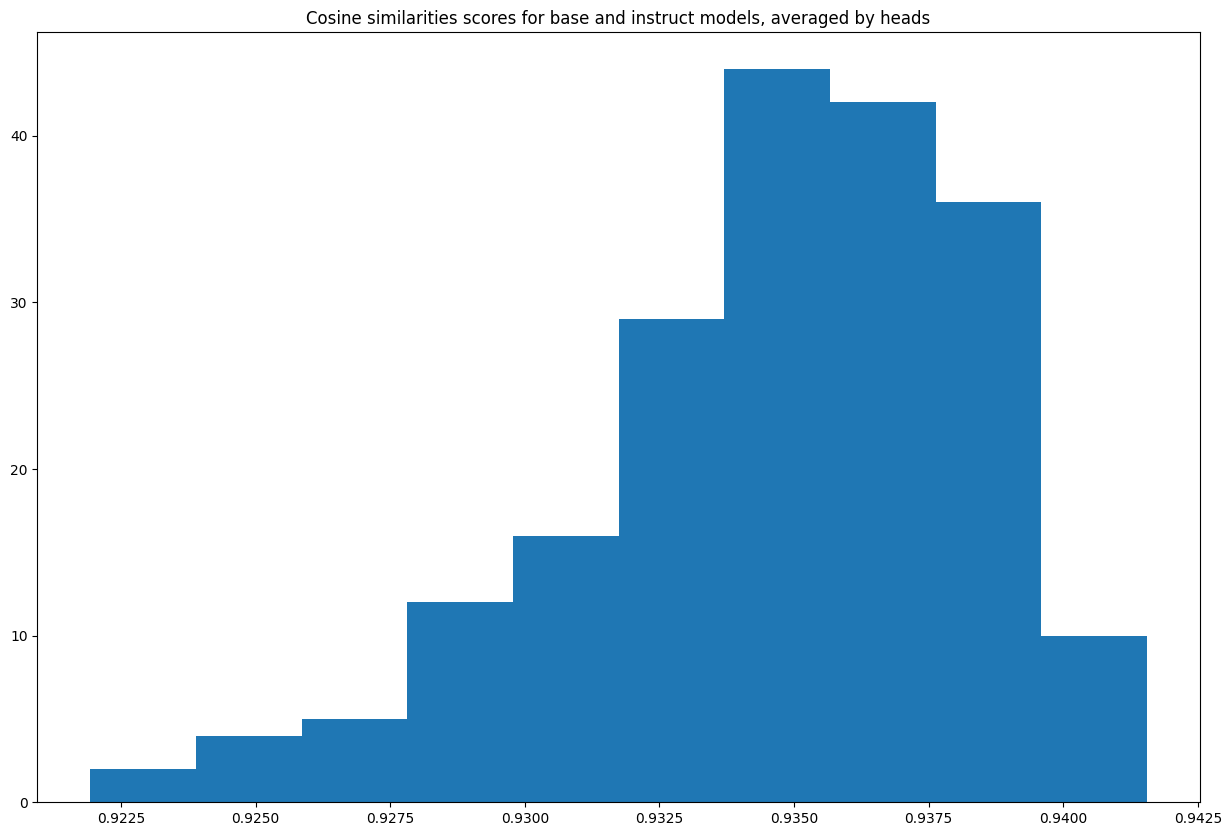

In [41]:
import numpy as np
mean_scores = np.zeros(200)
for idx in range(len(safety_heads)):
    mean_scores += heads_scores[idx]
mean_scores /= len(safety_heads)

plt.figure(figsize=(15, 10))
plt.hist(mean_scores)
plt.title(f'Cosine similarities scores for base and instruct models, averaged by heads')
plt.savefig('heads_mean.png')
plt.show()

In [15]:
safe_cache = {}
for layer, head in safety_heads:
    safe_cache[(layer, head)] = cache["pattern", layer][head]

In [18]:
safe_cache[safety_heads[0]].shape

torch.Size([24, 24])

In [8]:
[cache[key].shape for key in cache.keys()]

[torch.Size([24, 2048]),
 torch.Size([24, 2048]),
 torch.Size([24, 1]),
 torch.Size([24, 2048]),
 torch.Size([24, 8, 256]),
 torch.Size([24, 1, 256]),
 torch.Size([24, 1, 256]),
 torch.Size([24, 8, 256]),
 torch.Size([24, 1, 256]),
 torch.Size([8, 24, 24]),
 torch.Size([8, 24, 24]),
 torch.Size([24, 8, 256]),
 torch.Size([24, 2048]),
 torch.Size([24, 2048]),
 torch.Size([24, 1]),
 torch.Size([24, 2048]),
 torch.Size([24, 16384]),
 torch.Size([24, 16384]),
 torch.Size([24, 16384]),
 torch.Size([24, 2048]),
 torch.Size([24, 2048]),
 torch.Size([24, 2048]),
 torch.Size([24, 1]),
 torch.Size([24, 2048]),
 torch.Size([24, 8, 256]),
 torch.Size([24, 1, 256]),
 torch.Size([24, 1, 256]),
 torch.Size([24, 8, 256]),
 torch.Size([24, 1, 256]),
 torch.Size([8, 24, 24]),
 torch.Size([8, 24, 24]),
 torch.Size([24, 8, 256]),
 torch.Size([24, 2048]),
 torch.Size([24, 2048]),
 torch.Size([24, 1]),
 torch.Size([24, 2048]),
 torch.Size([24, 16384]),
 torch.Size([24, 16384]),
 torch.Size([24, 16384]),
 to

In [11]:
cache.keys()

dict_keys(['hook_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_rot_q', 'blocks.0.attn.hook_rot_k', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_pre_linear', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_rot_q', 'blocks.1.attn.hook_rot_k', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.m

In [17]:
safety_heads

[(0, 4),
 (0, 6),
 (1, 3),
 (3, 1),
 (3, 2),
 (3, 5),
 (4, 5),
 (4, 6),
 (4, 7),
 (5, 2),
 (5, 6),
 (5, 7),
 (6, 1),
 (6, 4),
 (6, 5),
 (7, 1),
 (7, 2),
 (7, 3),
 (9, 1),
 (9, 2),
 (9, 3),
 (10, 1),
 (11, 1),
 (11, 6),
 (12, 2),
 (12, 3),
 (13, 1),
 (13, 2),
 (14, 0),
 (14, 1),
 (14, 5),
 (15, 2),
 (15, 4),
 (15, 5),
 (15, 6),
 (15, 7),
 (16, 1),
 (16, 3),
 (16, 5),
 (16, 7),
 (17, 2),
 (17, 3),
 (17, 7)]